# 10장 튜닝 기법

* "부록3 매트플롯립 입문"에서 한글 폰트를 올바르게 출력하기 위한 설치 방법을 설명했다. 설치 방법은 다음과 같다.

In [ ]:
!sudo apt-get install -y fonts-nanum* | tail -n 1
!sudo fc-cache -fv
!rm -rf ~/.cache/matplotlib

debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 4.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Processing triggers for fontconfig (2.12.6-0ubuntu2) ...
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 31 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such 

In [3]:
# 필요 라이브러리 설치

!pip install torchviz | tail -n 1
!pip install torchinfo | tail -n 1

* 모든 설치가 끝나면 한글 폰트를 바르게 출력하기 위해 **[런타임]** -> **[런타임 다시시작]**을 클릭한 다음, 아래 셀부터 코드를 실행해 주십시오.

In [ ]:
# 라이브러리 임포트

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

# 폰트 관련 용도
import matplotlib.font_manager as fm

# 나눔 고딕 폰트의 경로 명시
path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
font_name = fm.FontProperties(fname=path, size=10).get_name()

In [4]:
# 파이토치 관련 라이브러리

import torch
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
from torchviz import make_dot
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torchvision.datasets as datasets

In [ ]:
# warning 표시 끄기
import warnings
warnings.simplefilter('ignore')

# 기본 폰트 설정
plt.rcParams['font.family'] = font_name

# 기본 폰트 사이즈 변경
plt.rcParams['font.size'] = 14

# 기본 그래프 사이즈 변경
plt.rcParams['figure.figsize'] = (6,6)

# 기본 그리드 표시
# 필요에 따라 설정할 때는, plt.grid()
plt.rcParams['axes.grid'] = True

# 마이너스 기호 정상 출력
plt.rcParams['axes.unicode_minus'] = False

# 넘파이 부동소수점 자릿수 표시
np.set_printoptions(suppress=True, precision=4)

In [ ]:
# GPU 디바이스 할당

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
# 분류 클래스 명칭 리스트
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# 분류 클래스 수,　10
n_output = len(list(set(classes)))

# 결과 확인
print(n_output)

10


## 10.4 과학습의 대응 방법

### 드랍 아웃 함수 동작 확인

In [ ]:
# 드랍 아웃 실험용 더미 데이터 작성

torch.manual_seed(123)
inputs = torch.randn(1, 10)
print(inputs)

tensor([[-0.1115,  0.1204, -0.3696, -0.2404, -1.1969,  0.2093, -0.9724, -0.7550,
          0.3239, -0.1085]])


In [ ]:
# 드랍 아웃 함수 정의
dropout = nn.Dropout(0.5)

# 훈련 페이즈에서의 거동
dropout.train()
print(dropout.training)
outputs = dropout(inputs)
print(outputs)

# 예측 페이즈에서의 거동
dropout.eval()
print(dropout.training)
outputs = dropout(inputs)
print(outputs)

True
tensor([[-0.0000,  0.2407, -0.0000, -0.4808, -0.0000,  0.0000, -1.9447, -0.0000,
          0.6478, -0.2170]])
False
tensor([[-0.1115,  0.1204, -0.3696, -0.2404, -1.1969,  0.2093, -0.9724, -0.7550,
          0.3239, -0.1085]])


## 10.5 공통 함수의 라이브러리화

In [5]:
# 공통 함수 다운로드
!git clone https://github.com/wikibook/pythonlibs.git

# 공통 함수 불러오기
from pythonlibs.torch_lib1 import *

# 공통 함수 확인
print(README)

fatal: destination path 'pythonlibs' already exists and is not an empty directory.
Common Library for PyTorch
Author: M. Akaishi


## 데이터 준비

In [ ]:
# Transforms의 정의

transform = transforms.Compose([
  transforms.ToTensor(),
  transforms.Normalize(0.5, 0.5)
])

In [ ]:
# 데이터 취득용 함수 dataset

data_root = './data'

train_set = datasets.CIFAR10(
    root = data_root, train = True, 
    download = True, transform = transform)

# 검증 데이터셋
test_set = datasets.CIFAR10(
    root = data_root, train = False, 
    download = True, transform = transform)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
# 미니 배치 사이즈 지정
batch_size = 100

# 훈련용 데이터로더
# 훈련용이므로 셔플을 True로 설정
train_loader = DataLoader(train_set, 
    batch_size = batch_size, shuffle = True)

# 검증용 데이터로더
# 검증용이므로 셔플하지 않음
test_loader = DataLoader(test_set,  
    batch_size = batch_size, shuffle = False) 

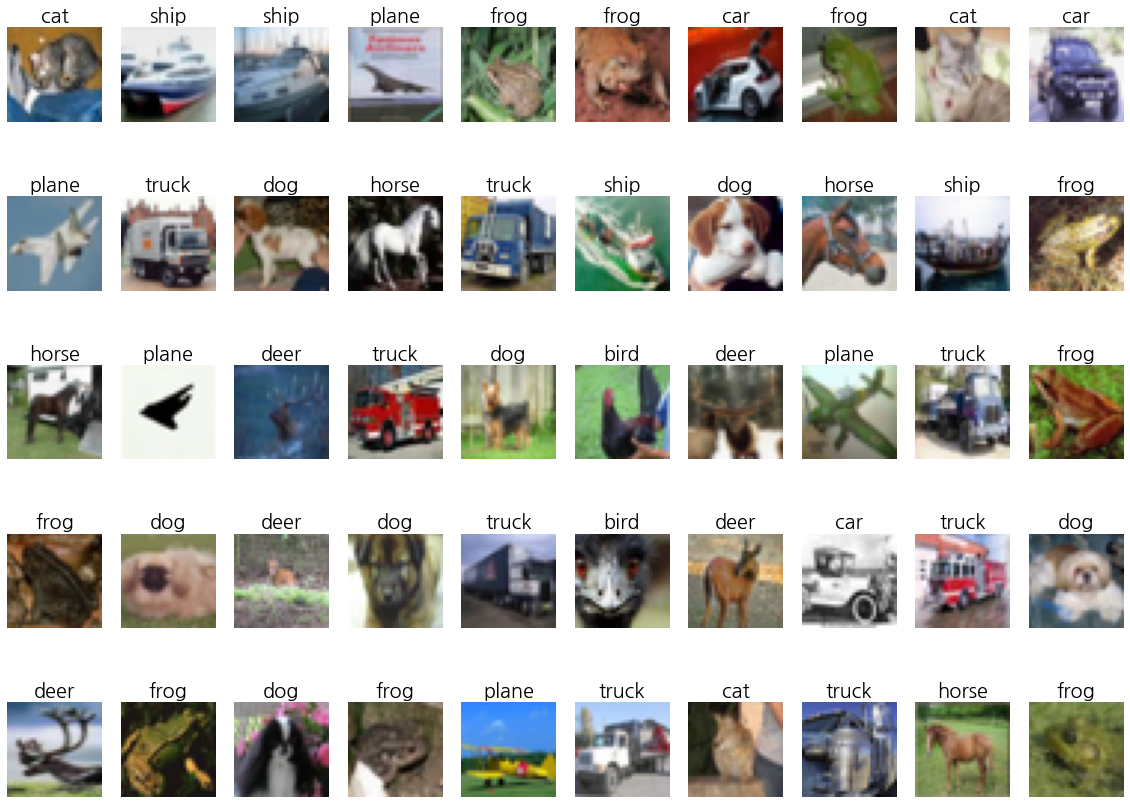

In [ ]:
# 처음 50개 이미지 출력
show_images_labels(test_loader, classes, None, None)

## 10.6 층을 깊게 쌓은 모델 구현하기

In [ ]:
class CNN_v2(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=(1,1))
        self.conv2 = nn.Conv2d(32, 32, 3, padding=(1,1))
        self.conv3 = nn.Conv2d(32, 64, 3, padding=(1,1))
        self.conv4 = nn.Conv2d(64, 64, 3, padding=(1,1))
        self.conv5 = nn.Conv2d(64, 128, 3, padding=(1,1))
        self.conv6 = nn.Conv2d(128, 128, 3, padding=(1,1))
        self.relu = nn.ReLU(inplace=True)
        self.flatten = nn.Flatten()
        self.maxpool = nn.MaxPool2d((2,2))
        self.l1 = nn.Linear(4*4*128, 128)
        self.l2 = nn.Linear(128, 10)

        self.features = nn.Sequential(
            self.conv1,
            self.relu,
            self.conv2,
            self.relu,
            self.maxpool,
            self.conv3,
            self.relu,
            self.conv4,
            self.relu,
            self.maxpool,
            self.conv5,
            self.relu,
            self.conv6,
            self.relu,
            self.maxpool,
            )

        self.classifier = nn.Sequential(
            self.l1,
            self.relu,
            self.l2
        )

    def forward(self, x):
        x1 = self.features(x)
        x2 = self.flatten(x1)
        x3 = self.classifier(x2)
        return x3

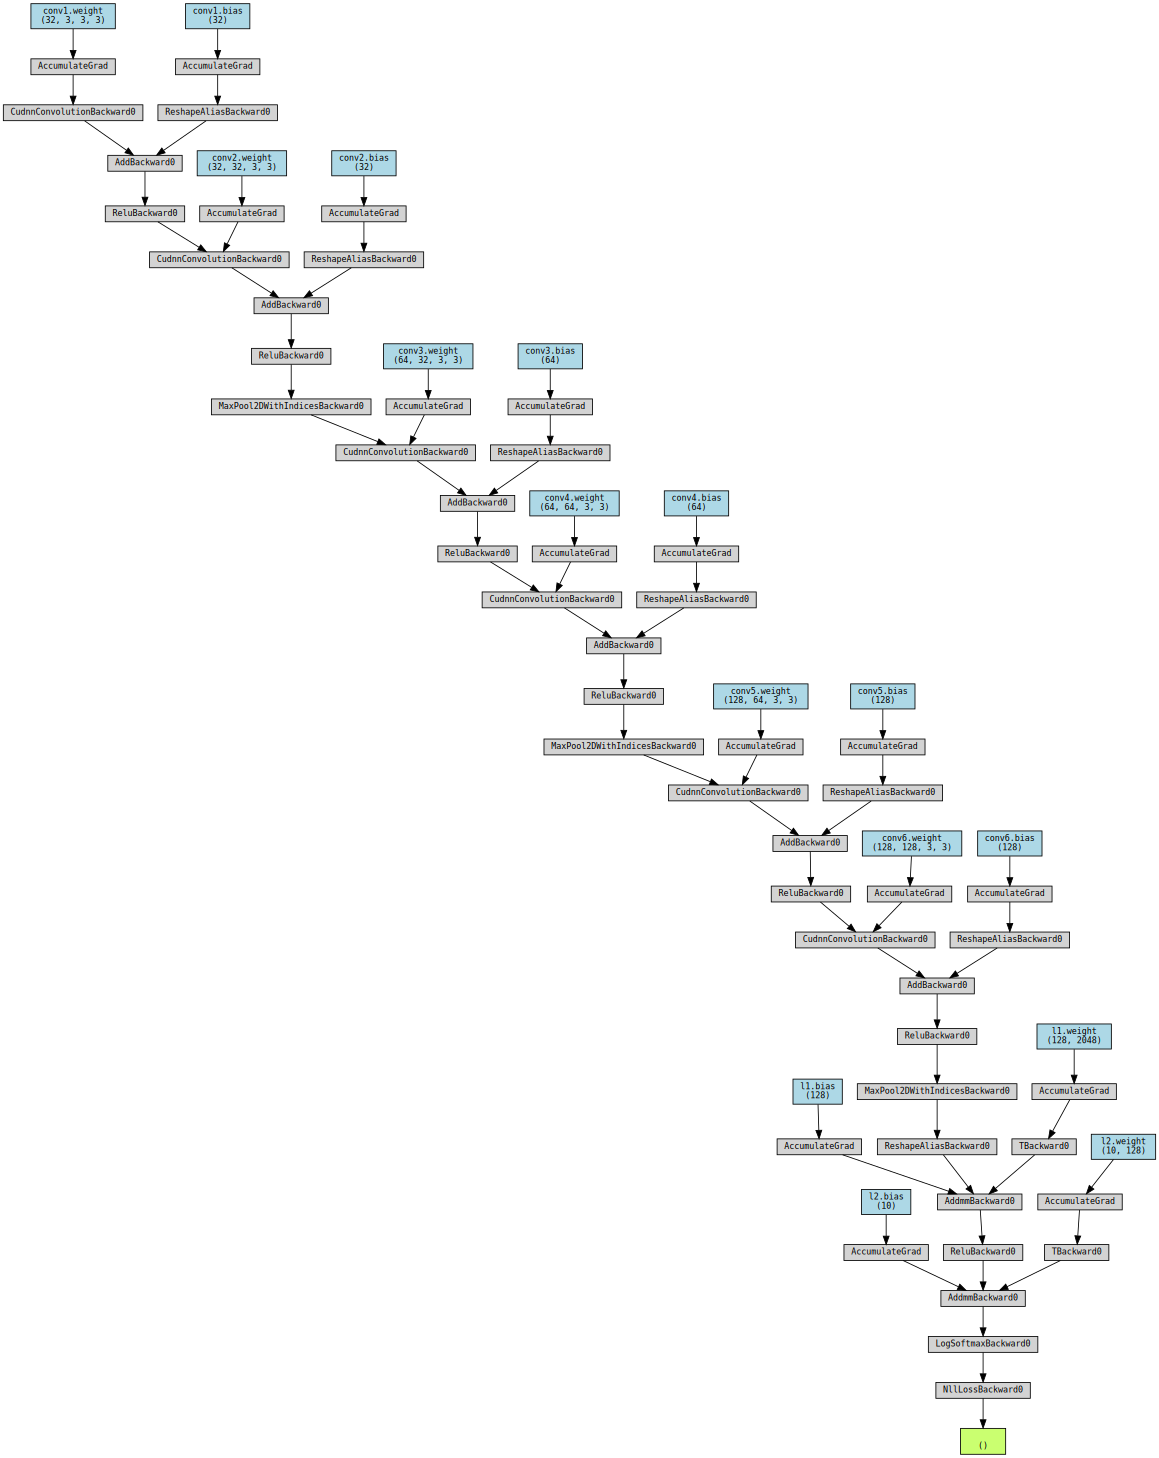

In [ ]:
# 손실 계산 그래프 시각화
net = CNN_v2(n_output).to(device)
criterion = nn.CrossEntropyLoss()
loss = eval_loss(test_loader, device, net, criterion)
g = make_dot(loss, params=dict(net.named_parameters()))
display(g)

In [ ]:
# 난수 고정
torch_seed()

# 모델 인스턴스 생성
lr = 0.01
net = CNN_v2(n_output).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=lr)
history = np.zeros((0, 5))

In [ ]:
# 학습

num_epochs = 50
history = fit(net, optimizer, criterion, num_epochs, train_loader, test_loader, device, history)

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [1/50], loss: 0.02303 acc: 0.10000 val_loss: 0.02303, val_acc: 0.10000


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [2/50], loss: 0.02303 acc: 0.10000 val_loss: 0.02303, val_acc: 0.10000


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [3/50], loss: 0.02302 acc: 0.10000 val_loss: 0.02302, val_acc: 0.10000


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [4/50], loss: 0.02302 acc: 0.10844 val_loss: 0.02302, val_acc: 0.10170


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [5/50], loss: 0.02302 acc: 0.13022 val_loss: 0.02302, val_acc: 0.17460


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [6/50], loss: 0.02301 acc: 0.16752 val_loss: 0.02300, val_acc: 0.19110


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [7/50], loss: 0.02298 acc: 0.18538 val_loss: 0.02294, val_acc: 0.21830


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [8/50], loss: 0.02245 acc: 0.21902 val_loss: 0.02096, val_acc: 0.23870


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [9/50], loss: 0.02016 acc: 0.26112 val_loss: 0.01945, val_acc: 0.29320


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [10/50], loss: 0.01906 acc: 0.31280 val_loss: 0.01902, val_acc: 0.30950


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [11/50], loss: 0.01796 acc: 0.35134 val_loss: 0.01700, val_acc: 0.38680


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [12/50], loss: 0.01697 acc: 0.38370 val_loss: 0.01626, val_acc: 0.41110


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [13/50], loss: 0.01628 acc: 0.40634 val_loss: 0.01559, val_acc: 0.42940


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [14/50], loss: 0.01574 acc: 0.42132 val_loss: 0.01614, val_acc: 0.41580


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [15/50], loss: 0.01530 acc: 0.43706 val_loss: 0.01508, val_acc: 0.44480


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [16/50], loss: 0.01482 acc: 0.45820 val_loss: 0.01439, val_acc: 0.47380


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [17/50], loss: 0.01440 acc: 0.47416 val_loss: 0.01401, val_acc: 0.48410


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [18/50], loss: 0.01399 acc: 0.49352 val_loss: 0.01410, val_acc: 0.48860


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [19/50], loss: 0.01355 acc: 0.51304 val_loss: 0.01330, val_acc: 0.51780


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [20/50], loss: 0.01310 acc: 0.53294 val_loss: 0.01286, val_acc: 0.53320


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [21/50], loss: 0.01259 acc: 0.55006 val_loss: 0.01233, val_acc: 0.55430


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [22/50], loss: 0.01217 acc: 0.56674 val_loss: 0.01212, val_acc: 0.56560


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [23/50], loss: 0.01174 acc: 0.58244 val_loss: 0.01200, val_acc: 0.57330


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [24/50], loss: 0.01140 acc: 0.59590 val_loss: 0.01160, val_acc: 0.58420


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [25/50], loss: 0.01098 acc: 0.61156 val_loss: 0.01127, val_acc: 0.59440


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [26/50], loss: 0.01060 acc: 0.62456 val_loss: 0.01101, val_acc: 0.61150


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [27/50], loss: 0.01022 acc: 0.64120 val_loss: 0.01127, val_acc: 0.60360


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [28/50], loss: 0.00985 acc: 0.65304 val_loss: 0.01052, val_acc: 0.63110


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [29/50], loss: 0.00955 acc: 0.66724 val_loss: 0.01000, val_acc: 0.65160


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [30/50], loss: 0.00917 acc: 0.68006 val_loss: 0.00974, val_acc: 0.65760


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [31/50], loss: 0.00885 acc: 0.69082 val_loss: 0.00964, val_acc: 0.66290


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [32/50], loss: 0.00857 acc: 0.69910 val_loss: 0.00946, val_acc: 0.67100


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [33/50], loss: 0.00823 acc: 0.71176 val_loss: 0.01005, val_acc: 0.65280


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [34/50], loss: 0.00794 acc: 0.72390 val_loss: 0.00918, val_acc: 0.68170


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [35/50], loss: 0.00761 acc: 0.73616 val_loss: 0.00955, val_acc: 0.67300


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [36/50], loss: 0.00734 acc: 0.74286 val_loss: 0.00933, val_acc: 0.68010


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [37/50], loss: 0.00706 acc: 0.75246 val_loss: 0.00947, val_acc: 0.68520


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [38/50], loss: 0.00674 acc: 0.76688 val_loss: 0.00907, val_acc: 0.69210


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [39/50], loss: 0.00643 acc: 0.77620 val_loss: 0.00900, val_acc: 0.70050


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [40/50], loss: 0.00617 acc: 0.78348 val_loss: 0.00944, val_acc: 0.68380


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [41/50], loss: 0.00587 acc: 0.79738 val_loss: 0.00974, val_acc: 0.68310


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [42/50], loss: 0.00559 acc: 0.80460 val_loss: 0.00938, val_acc: 0.69830


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [43/50], loss: 0.00527 acc: 0.81536 val_loss: 0.00920, val_acc: 0.70120


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [44/50], loss: 0.00498 acc: 0.82606 val_loss: 0.00931, val_acc: 0.70290


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [45/50], loss: 0.00470 acc: 0.83650 val_loss: 0.01024, val_acc: 0.68950


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [46/50], loss: 0.00440 acc: 0.84618 val_loss: 0.00976, val_acc: 0.70860


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [47/50], loss: 0.00409 acc: 0.85618 val_loss: 0.01004, val_acc: 0.70030


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [48/50], loss: 0.00376 acc: 0.86970 val_loss: 0.01048, val_acc: 0.70200


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [49/50], loss: 0.00349 acc: 0.87594 val_loss: 0.01080, val_acc: 0.69580


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [50/50], loss: 0.00316 acc: 0.88994 val_loss: 0.01104, val_acc: 0.69660


초기상태 : 손실 : 0.02303  정확도 : 0.10000
최종상태 : 손실 : 0.01104 정확도 : 0.69660


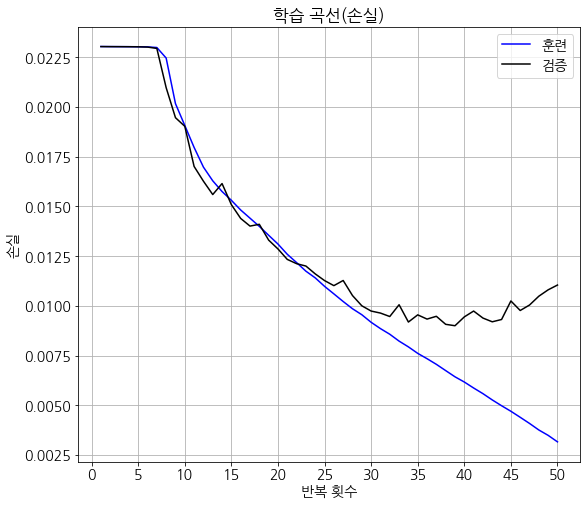

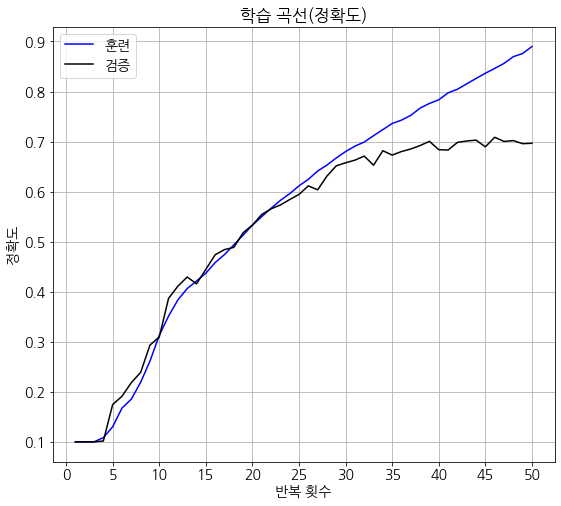

In [ ]:
evaluate_history(history)

## 10.7 최적화 함수 선택

### 모멘텀 설정

In [ ]:
# 난수 고정
torch_seed()

# 모델 인스턴스 생성
lr = 0.01
net = CNN_v2(n_output).to(device)
criterion = nn.CrossEntropyLoss()

# 최적화 함수에 모멘텀 값 설정
optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9)
history2 = np.zeros((0, 5))

In [ ]:
# 학습

num_epochs = 20
history2 = fit(net, optimizer, criterion, num_epochs, train_loader, test_loader, device, history2)

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [1/20], loss: 0.02282 acc: 0.12330 val_loss: 0.02039, val_acc: 0.25510


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [2/20], loss: 0.01795 acc: 0.33826 val_loss: 0.01541, val_acc: 0.42520


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [3/20], loss: 0.01412 acc: 0.48134 val_loss: 0.01286, val_acc: 0.53560


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [4/20], loss: 0.01166 acc: 0.58086 val_loss: 0.01088, val_acc: 0.61590


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [5/20], loss: 0.00972 acc: 0.65554 val_loss: 0.00927, val_acc: 0.67070


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [6/20], loss: 0.00817 acc: 0.71382 val_loss: 0.00822, val_acc: 0.71680


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [7/20], loss: 0.00685 acc: 0.75988 val_loss: 0.00792, val_acc: 0.72860


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [8/20], loss: 0.00582 acc: 0.79620 val_loss: 0.00726, val_acc: 0.75170


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [9/20], loss: 0.00498 acc: 0.82544 val_loss: 0.00718, val_acc: 0.75300


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [10/20], loss: 0.00417 acc: 0.85348 val_loss: 0.00746, val_acc: 0.75950


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [11/20], loss: 0.00346 acc: 0.87918 val_loss: 0.00817, val_acc: 0.75490


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [12/20], loss: 0.00283 acc: 0.90032 val_loss: 0.00817, val_acc: 0.76390


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [13/20], loss: 0.00226 acc: 0.92002 val_loss: 0.00846, val_acc: 0.75980


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [14/20], loss: 0.00198 acc: 0.92934 val_loss: 0.00865, val_acc: 0.77000


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [15/20], loss: 0.00157 acc: 0.94428 val_loss: 0.01011, val_acc: 0.76710


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [16/20], loss: 0.00135 acc: 0.95248 val_loss: 0.01053, val_acc: 0.76540


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [17/20], loss: 0.00127 acc: 0.95500 val_loss: 0.01285, val_acc: 0.75050


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [18/20], loss: 0.00109 acc: 0.96098 val_loss: 0.01165, val_acc: 0.76500


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [19/20], loss: 0.00097 acc: 0.96534 val_loss: 0.01293, val_acc: 0.76580


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [20/20], loss: 0.00089 acc: 0.96894 val_loss: 0.01237, val_acc: 0.76560


초기상태 : 손실 : 0.02039  정확도 : 0.25510
최종상태 : 손실 : 0.01237 정확도 : 0.76560


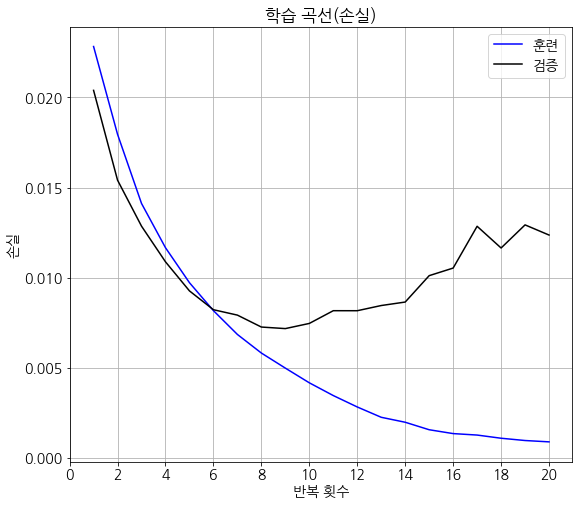

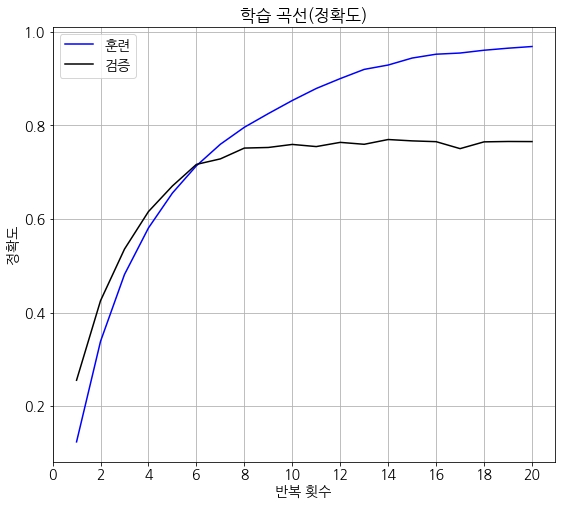

In [ ]:
evaluate_history(history2)

### Adam 함수 사용

In [ ]:
# 난수 고정
torch_seed()

# 모델 인스턴스 생성
net = CNN_v2(n_output).to(device)
criterion = nn.CrossEntropyLoss()

# 최적화 함수를 Adam으로 교체
optimizer = optim.Adam(net.parameters())
history3 = np.zeros((0, 5))

In [ ]:
print(optimizer)

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)


In [ ]:
# 학습

num_epochs = 20
history3 = fit(net, optimizer, criterion, num_epochs, train_loader, test_loader, device, history3)

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [1/20], loss: 0.01597 acc: 0.41390 val_loss: 0.01271, val_acc: 0.53850


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [2/20], loss: 0.01103 acc: 0.60442 val_loss: 0.01040, val_acc: 0.63170


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [3/20], loss: 0.00890 acc: 0.68548 val_loss: 0.00891, val_acc: 0.68670


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [4/20], loss: 0.00736 acc: 0.74040 val_loss: 0.00831, val_acc: 0.70850


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [5/20], loss: 0.00624 acc: 0.78128 val_loss: 0.00726, val_acc: 0.75250


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [6/20], loss: 0.00534 acc: 0.81186 val_loss: 0.00713, val_acc: 0.75710


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [7/20], loss: 0.00450 acc: 0.84224 val_loss: 0.00715, val_acc: 0.75980


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [8/20], loss: 0.00376 acc: 0.86974 val_loss: 0.00755, val_acc: 0.76570


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [9/20], loss: 0.00312 acc: 0.88940 val_loss: 0.00769, val_acc: 0.76420


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [10/20], loss: 0.00252 acc: 0.91078 val_loss: 0.00866, val_acc: 0.75990


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [11/20], loss: 0.00209 acc: 0.92510 val_loss: 0.00944, val_acc: 0.75280


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [12/20], loss: 0.00174 acc: 0.93718 val_loss: 0.01018, val_acc: 0.76320


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [13/20], loss: 0.00148 acc: 0.94696 val_loss: 0.01069, val_acc: 0.76050


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [14/20], loss: 0.00130 acc: 0.95378 val_loss: 0.01158, val_acc: 0.76680


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [15/20], loss: 0.00113 acc: 0.95886 val_loss: 0.01219, val_acc: 0.76460


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [16/20], loss: 0.00111 acc: 0.96116 val_loss: 0.01179, val_acc: 0.76240


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [17/20], loss: 0.00098 acc: 0.96530 val_loss: 0.01275, val_acc: 0.76590


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [18/20], loss: 0.00087 acc: 0.96942 val_loss: 0.01402, val_acc: 0.76370


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [19/20], loss: 0.00090 acc: 0.96846 val_loss: 0.01396, val_acc: 0.77050


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [20/20], loss: 0.00090 acc: 0.96892 val_loss: 0.01384, val_acc: 0.76560


초기상태 : 손실 : 0.01271  정확도 : 0.53850
최종상태 : 손실 : 0.01384 정확도 : 0.76560


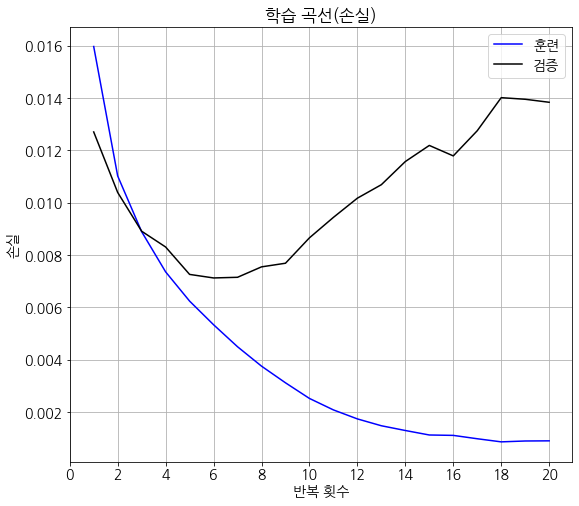

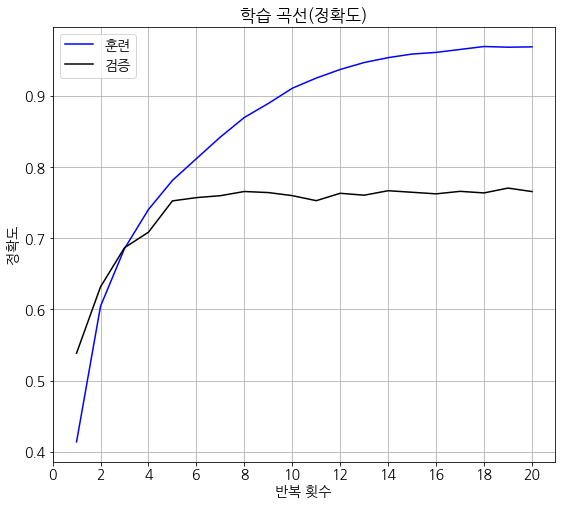

In [ ]:
evaluate_history(history3)

### 결과 비교

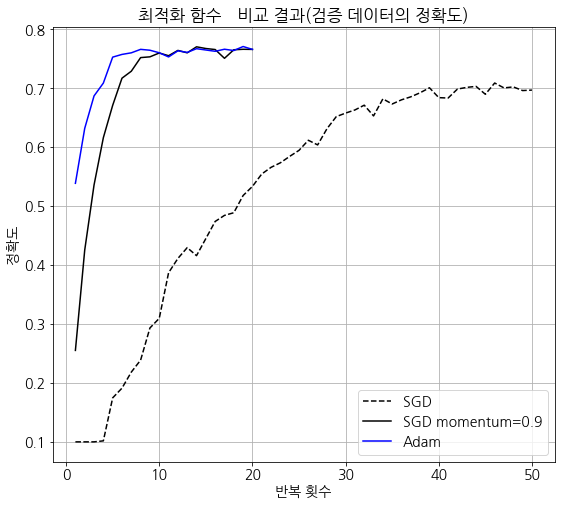

In [ ]:
# 결과 비교(검증 데이터의 정확도)
plt.figure(figsize=(9,8))
plt.plot(history[:,0], history[:,4], label='SGD', c='k',ls='dashed' )
plt.plot(history2[:,0], history2[:,4], label='SGD momentum=0.9', c='k')
plt.plot(history3[:,0], history3[:,4], label='Adam', c='b')
plt.title('최적화 함수　비교 결과(검증 데이터의 정확도)')
plt.xlabel('반복 횟수')
plt.ylabel('정확도')
plt.legend()
plt.show()

## 10.8 드랍 아웃

In [ ]:
# 모델 정의

class CNN_v3(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=(1,1))
        self.conv2 = nn.Conv2d(32, 32, 3, padding=(1,1))
        self.conv3 = nn.Conv2d(32, 64, 3, padding=(1,1))
        self.conv4 = nn.Conv2d(64, 64, 3, padding=(1,1))
        self.conv5 = nn.Conv2d(64, 128, 3, padding=(1,1))
        self.conv6 = nn.Conv2d(128, 128, 3, padding=(1,1))
        self.relu = nn.ReLU(inplace=True)
        self.flatten = nn.Flatten()
        self.maxpool = nn.MaxPool2d((2,2))
        self.l1 = nn.Linear(4*4*128, 128)
        self.l2 = nn.Linear(128, 10)
        self.dropout1 = nn.Dropout(0.2)
        self.dropout2 = nn.Dropout(0.3)
        self.dropout3 = nn.Dropout(0.4)

        self.features = nn.Sequential(
            self.conv1,
            self.relu,
            self.conv2,
            self.relu,
            self.maxpool,
            self.dropout1,
            self.conv3,
            self.relu,
            self.conv4,
            self.relu,
            self.maxpool,
            self.dropout2,
            self.conv5,
            self.relu,
            self.conv6,
            self.relu,
            self.maxpool,
            self.dropout3,
            )

        self.classifier = nn.Sequential(
            self.l1,
            self.relu,
            self.dropout3,
            self.l2
        )

    def forward(self, x):
        x1 = self.features(x)
        x2 = self.flatten(x1)
        x3 = self.classifier(x2)
        return x3

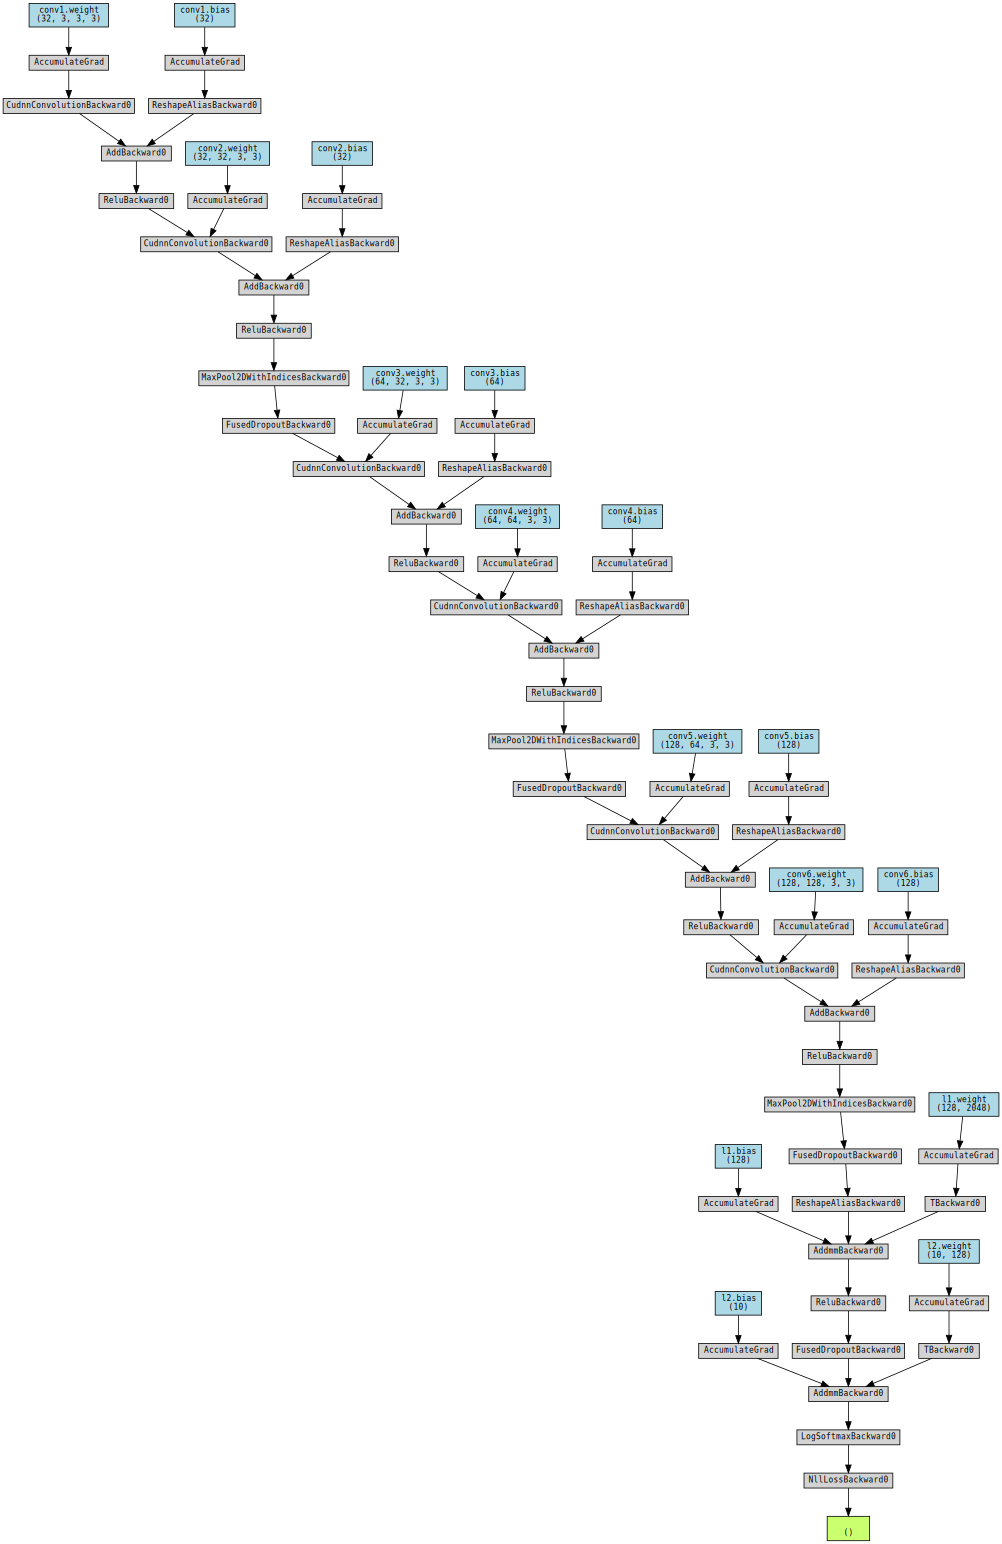

In [ ]:
# 손실 계산 그래프 시각화
net = CNN_v3(n_output).to(device)
criterion = nn.CrossEntropyLoss()
loss = eval_loss(test_loader, device, net, criterion)
g = make_dot(loss, params=dict(net.named_parameters()))
display(g)

In [ ]:
# 난수 고정
torch_seed()

# 모델 인스턴스 생성
net = CNN_v3(n_output).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())
history = np.zeros((0, 5))

In [ ]:
# 학습

num_epochs = 50
history = fit(net, optimizer, criterion, num_epochs, train_loader, test_loader, device, history)

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [1/50], loss: 0.01708 acc: 0.36302 val_loss: 0.01316, val_acc: 0.51280


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [2/50], loss: 0.01290 acc: 0.53036 val_loss: 0.01072, val_acc: 0.61480


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [3/50], loss: 0.01131 acc: 0.59562 val_loss: 0.00982, val_acc: 0.65760


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [4/50], loss: 0.01005 acc: 0.64556 val_loss: 0.00856, val_acc: 0.69540


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [5/50], loss: 0.00918 acc: 0.68006 val_loss: 0.00784, val_acc: 0.72310


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [6/50], loss: 0.00849 acc: 0.70518 val_loss: 0.00746, val_acc: 0.73910


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [7/50], loss: 0.00788 acc: 0.72872 val_loss: 0.00713, val_acc: 0.75240


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [8/50], loss: 0.00748 acc: 0.74072 val_loss: 0.00704, val_acc: 0.75630


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [9/50], loss: 0.00712 acc: 0.75614 val_loss: 0.00651, val_acc: 0.77520


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [10/50], loss: 0.00684 acc: 0.76476 val_loss: 0.00630, val_acc: 0.78220


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [11/50], loss: 0.00658 acc: 0.77220 val_loss: 0.00655, val_acc: 0.77470


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [12/50], loss: 0.00631 acc: 0.78142 val_loss: 0.00600, val_acc: 0.79630


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [13/50], loss: 0.00608 acc: 0.79122 val_loss: 0.00582, val_acc: 0.80450


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [14/50], loss: 0.00597 acc: 0.79578 val_loss: 0.00579, val_acc: 0.80290


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [15/50], loss: 0.00585 acc: 0.79554 val_loss: 0.00559, val_acc: 0.81120


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [16/50], loss: 0.00568 acc: 0.80400 val_loss: 0.00568, val_acc: 0.80650


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [17/50], loss: 0.00556 acc: 0.80756 val_loss: 0.00574, val_acc: 0.80300


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [18/50], loss: 0.00547 acc: 0.81032 val_loss: 0.00554, val_acc: 0.81240


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [19/50], loss: 0.00534 acc: 0.81462 val_loss: 0.00558, val_acc: 0.81490


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [20/50], loss: 0.00520 acc: 0.81954 val_loss: 0.00584, val_acc: 0.80500


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [21/50], loss: 0.00508 acc: 0.82456 val_loss: 0.00555, val_acc: 0.81800


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [22/50], loss: 0.00507 acc: 0.82494 val_loss: 0.00561, val_acc: 0.81850


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [23/50], loss: 0.00494 acc: 0.82848 val_loss: 0.00566, val_acc: 0.81390


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [24/50], loss: 0.00494 acc: 0.82974 val_loss: 0.00536, val_acc: 0.81910


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [25/50], loss: 0.00484 acc: 0.83306 val_loss: 0.00547, val_acc: 0.82140


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [26/50], loss: 0.00477 acc: 0.83582 val_loss: 0.00570, val_acc: 0.81580


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [27/50], loss: 0.00466 acc: 0.83730 val_loss: 0.00542, val_acc: 0.82550


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [28/50], loss: 0.00466 acc: 0.83856 val_loss: 0.00540, val_acc: 0.82630


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [29/50], loss: 0.00460 acc: 0.84164 val_loss: 0.00529, val_acc: 0.82750


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [30/50], loss: 0.00455 acc: 0.84204 val_loss: 0.00526, val_acc: 0.82930


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [31/50], loss: 0.00448 acc: 0.84460 val_loss: 0.00527, val_acc: 0.82980


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [32/50], loss: 0.00456 acc: 0.84154 val_loss: 0.00523, val_acc: 0.82940


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [33/50], loss: 0.00444 acc: 0.84530 val_loss: 0.00543, val_acc: 0.82750


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [34/50], loss: 0.00436 acc: 0.84756 val_loss: 0.00523, val_acc: 0.83000


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [35/50], loss: 0.00435 acc: 0.84810 val_loss: 0.00531, val_acc: 0.83270


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [36/50], loss: 0.00428 acc: 0.85138 val_loss: 0.00522, val_acc: 0.83200


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [37/50], loss: 0.00428 acc: 0.85124 val_loss: 0.00530, val_acc: 0.83300


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [38/50], loss: 0.00418 acc: 0.85270 val_loss: 0.00560, val_acc: 0.82480


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [39/50], loss: 0.00421 acc: 0.85518 val_loss: 0.00550, val_acc: 0.82820


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [40/50], loss: 0.00419 acc: 0.85578 val_loss: 0.00531, val_acc: 0.83440


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [41/50], loss: 0.00414 acc: 0.85444 val_loss: 0.00536, val_acc: 0.83280


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [42/50], loss: 0.00412 acc: 0.85692 val_loss: 0.00527, val_acc: 0.83040


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [43/50], loss: 0.00404 acc: 0.86108 val_loss: 0.00521, val_acc: 0.83650


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [44/50], loss: 0.00398 acc: 0.86158 val_loss: 0.00535, val_acc: 0.83520


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [45/50], loss: 0.00398 acc: 0.86066 val_loss: 0.00518, val_acc: 0.84180


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [46/50], loss: 0.00399 acc: 0.86150 val_loss: 0.00530, val_acc: 0.83290


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [47/50], loss: 0.00387 acc: 0.86566 val_loss: 0.00564, val_acc: 0.83460


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [48/50], loss: 0.00390 acc: 0.86492 val_loss: 0.00542, val_acc: 0.83440


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [49/50], loss: 0.00386 acc: 0.86484 val_loss: 0.00537, val_acc: 0.83500


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [50/50], loss: 0.00390 acc: 0.86488 val_loss: 0.00559, val_acc: 0.83640


초기상태 : 손실 : 0.01316  정확도 : 0.51280
최종상태 : 손실 : 0.00559 정확도 : 0.83640


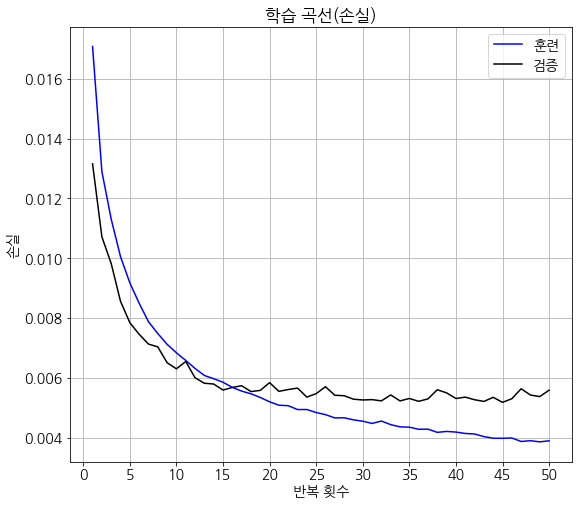

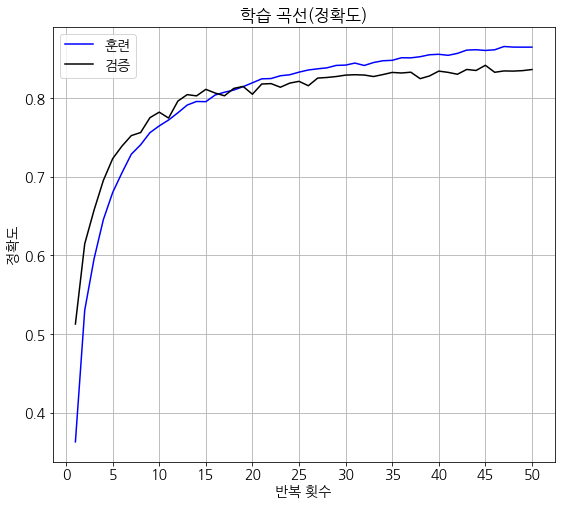

In [ ]:
evaluate_history(history)

## 10.9 배치 정규화

In [ ]:
class CNN_v4(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=(1,1))
        self.conv2 = nn.Conv2d(32, 32, 3, padding=(1,1))
        self.conv3 = nn.Conv2d(32, 64, 3, padding=(1,1))
        self.conv4 = nn.Conv2d(64, 64, 3, padding=(1,1))
        self.conv5 = nn.Conv2d(64, 128, 3, padding=(1,1))
        self.conv6 = nn.Conv2d(128, 128, 3, padding=(1,1))
        self.relu = nn.ReLU(inplace=True)
        self.flatten = nn.Flatten()
        self.maxpool = nn.MaxPool2d((2,2))
        self.l1 = nn.Linear(4*4*128, 128)
        self.l2 = nn.Linear(128, 10)
        self.dropout1 = nn.Dropout(0.2)
        self.dropout2 = nn.Dropout(0.3)
        self.dropout3 = nn.Dropout(0.4)
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(32)
        self.bn3 = nn.BatchNorm2d(64)
        self.bn4 = nn.BatchNorm2d(64)
        self.bn5 = nn.BatchNorm2d(128)
        self.bn6 = nn.BatchNorm2d(128)

        self.features = nn.Sequential(
            self.conv1,
            self.bn1,
            self.relu,
            self.conv2,
            self.bn2,
            self.relu,
            self.maxpool,
            self.dropout1,
            self.conv3,
            self.bn3,
            self.relu,
            self.conv4,
            self.bn4,
            self.relu,
            self.maxpool,
            self.dropout2,
            self.conv5,
            self.bn5,
            self.relu,
            self.conv6,
            self.bn6,
            self.relu,
            self.maxpool,
            self.dropout3,
            )

        self.classifier = nn.Sequential(
            self.l1,
            self.relu,
            self.dropout3,
            self.l2
        )

    def forward(self, x):
        x1 = self.features(x)
        x2 = self.flatten(x1)
        x3 = self.classifier(x2)
        return x3

In [ ]:
# 난수 고정
torch_seed()

# 모델 인스턴스 생성
net = CNN_v4(n_output).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())
history = np.zeros((0, 5))

In [ ]:
# 학습

num_epochs = 50
history = fit(net, optimizer, criterion, num_epochs, train_loader, test_loader, device, history)

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [1/50], loss: 0.01521 acc: 0.43682 val_loss: 0.01130, val_acc: 0.58510


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [2/50], loss: 0.01138 acc: 0.59314 val_loss: 0.01297, val_acc: 0.56840


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [3/50], loss: 0.00988 acc: 0.65316 val_loss: 0.00783, val_acc: 0.72350


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [4/50], loss: 0.00897 acc: 0.68582 val_loss: 0.00717, val_acc: 0.74760


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [5/50], loss: 0.00832 acc: 0.71476 val_loss: 0.00718, val_acc: 0.75180


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [6/50], loss: 0.00780 acc: 0.73334 val_loss: 0.00682, val_acc: 0.76480


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [7/50], loss: 0.00747 acc: 0.74378 val_loss: 0.00617, val_acc: 0.78240


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [8/50], loss: 0.00708 acc: 0.76038 val_loss: 0.00630, val_acc: 0.78390


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [9/50], loss: 0.00674 acc: 0.77086 val_loss: 0.00589, val_acc: 0.79750


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [10/50], loss: 0.00643 acc: 0.78330 val_loss: 0.00548, val_acc: 0.81210


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [11/50], loss: 0.00615 acc: 0.79472 val_loss: 0.00560, val_acc: 0.80910


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [12/50], loss: 0.00594 acc: 0.80016 val_loss: 0.00532, val_acc: 0.82230


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [13/50], loss: 0.00566 acc: 0.80796 val_loss: 0.00530, val_acc: 0.82400


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [14/50], loss: 0.00551 acc: 0.81362 val_loss: 0.00486, val_acc: 0.83290


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [15/50], loss: 0.00533 acc: 0.82350 val_loss: 0.00517, val_acc: 0.82660


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [16/50], loss: 0.00517 acc: 0.82714 val_loss: 0.00501, val_acc: 0.83220


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [17/50], loss: 0.00499 acc: 0.83294 val_loss: 0.00505, val_acc: 0.83310


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [18/50], loss: 0.00484 acc: 0.83548 val_loss: 0.00485, val_acc: 0.84150


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [19/50], loss: 0.00475 acc: 0.84164 val_loss: 0.00474, val_acc: 0.84400


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [20/50], loss: 0.00463 acc: 0.84498 val_loss: 0.00480, val_acc: 0.85060


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [21/50], loss: 0.00443 acc: 0.85320 val_loss: 0.00487, val_acc: 0.84410


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [22/50], loss: 0.00439 acc: 0.85336 val_loss: 0.00475, val_acc: 0.84660


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [23/50], loss: 0.00422 acc: 0.86096 val_loss: 0.00467, val_acc: 0.84830


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [24/50], loss: 0.00410 acc: 0.86236 val_loss: 0.00460, val_acc: 0.85260


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [25/50], loss: 0.00399 acc: 0.86542 val_loss: 0.00465, val_acc: 0.85110


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [26/50], loss: 0.00389 acc: 0.86814 val_loss: 0.00439, val_acc: 0.86050


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [27/50], loss: 0.00379 acc: 0.87090 val_loss: 0.00475, val_acc: 0.85280


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [28/50], loss: 0.00379 acc: 0.87356 val_loss: 0.00496, val_acc: 0.84630


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [29/50], loss: 0.00364 acc: 0.87666 val_loss: 0.00452, val_acc: 0.85770


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [30/50], loss: 0.00360 acc: 0.87904 val_loss: 0.00428, val_acc: 0.86720


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [31/50], loss: 0.00350 acc: 0.88210 val_loss: 0.00473, val_acc: 0.86030


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [32/50], loss: 0.00349 acc: 0.88376 val_loss: 0.00450, val_acc: 0.86430


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [33/50], loss: 0.00340 acc: 0.88468 val_loss: 0.00463, val_acc: 0.86030


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [34/50], loss: 0.00329 acc: 0.88900 val_loss: 0.00471, val_acc: 0.85750


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [35/50], loss: 0.00331 acc: 0.88820 val_loss: 0.00458, val_acc: 0.85840


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [36/50], loss: 0.00314 acc: 0.89362 val_loss: 0.00457, val_acc: 0.86370


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [37/50], loss: 0.00316 acc: 0.89258 val_loss: 0.00454, val_acc: 0.86240


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [38/50], loss: 0.00306 acc: 0.89502 val_loss: 0.00470, val_acc: 0.86240


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [39/50], loss: 0.00309 acc: 0.89482 val_loss: 0.00460, val_acc: 0.86370


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [40/50], loss: 0.00295 acc: 0.89900 val_loss: 0.00455, val_acc: 0.86570


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [41/50], loss: 0.00287 acc: 0.90314 val_loss: 0.00474, val_acc: 0.86520


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [42/50], loss: 0.00289 acc: 0.90320 val_loss: 0.00466, val_acc: 0.86380


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [43/50], loss: 0.00287 acc: 0.90176 val_loss: 0.00429, val_acc: 0.87320


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [44/50], loss: 0.00280 acc: 0.90362 val_loss: 0.00444, val_acc: 0.86870


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [45/50], loss: 0.00276 acc: 0.90634 val_loss: 0.00451, val_acc: 0.87130


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [46/50], loss: 0.00271 acc: 0.90780 val_loss: 0.00443, val_acc: 0.86960


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [47/50], loss: 0.00264 acc: 0.91076 val_loss: 0.00455, val_acc: 0.86850


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [48/50], loss: 0.00263 acc: 0.90980 val_loss: 0.00462, val_acc: 0.86920


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [49/50], loss: 0.00259 acc: 0.91236 val_loss: 0.00443, val_acc: 0.87020


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [50/50], loss: 0.00256 acc: 0.91222 val_loss: 0.00472, val_acc: 0.86600


초기상태 : 손실 : 0.01130  정확도 : 0.58510
최종상태 : 손실 : 0.00472 정확도 : 0.86600


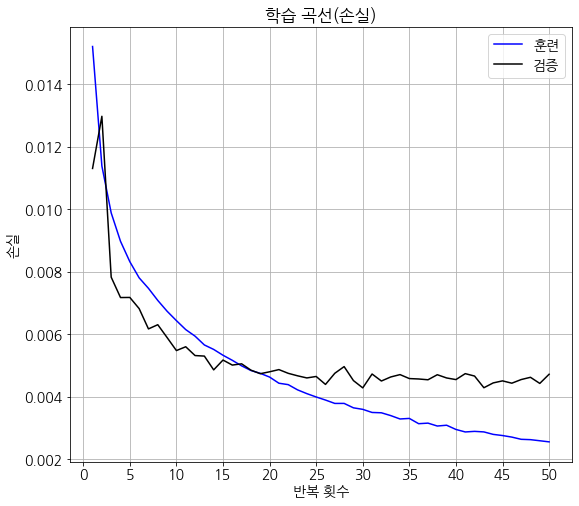

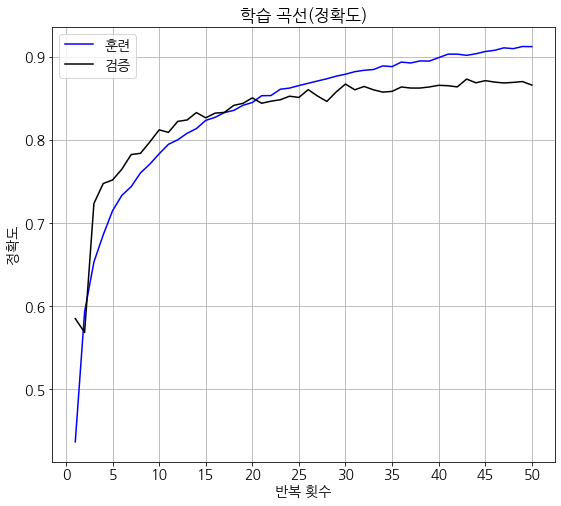

In [ ]:
evaluate_history(history)

## 10.10 데이터 증강 기법

In [ ]:
# 훈련 데이터용: 정규화에 반전과 RandomErasing 추가
transform_train = transforms.Compose([
  transforms.RandomHorizontalFlip(p=0.5), 
  transforms.ToTensor(),
  transforms.Normalize(0.5, 0.5), 
  transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0, inplace=False)
])

In [ ]:
# transfrom_train을 사용한 데이터셋 정의
train_set2 = datasets.CIFAR10(
    root = data_root, train = True, 
    download = True, transform = transform_train)

# traisform_train을 사용한 데이터로더 정의
batch_size = 100
train_loader2 = DataLoader(train_set2, batch_size=batch_size, shuffle=True)

Files already downloaded and verified


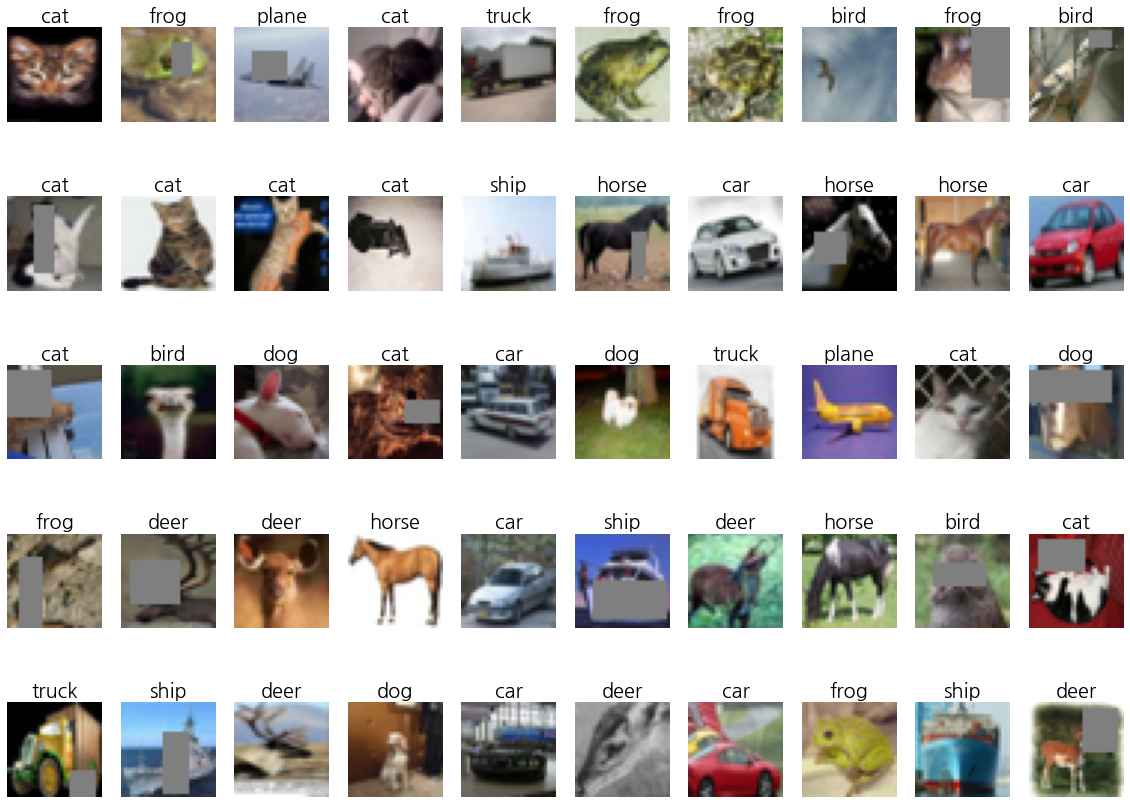

In [ ]:
# 새로운 훈련 데이터의 처음 50개 표시

# 난수 고정
torch_seed()

show_images_labels(train_loader2, classes, None, None)

In [ ]:
# 난수 고정
torch_seed()

# 모델 인스턴스 생성
net = CNN_v4(n_output).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())
history = np.zeros((0, 5))

In [ ]:
# 학습
# 동일한 모델에서 train_loader2로 데이터를 변경

num_epochs = 100
history = fit(net, optimizer, criterion, num_epochs, 
        train_loader2, test_loader, device, history)

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [1/100], loss: 0.01594 acc: 0.41022 val_loss: 0.01259, val_acc: 0.54220


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [2/100], loss: 0.01253 acc: 0.55450 val_loss: 0.01067, val_acc: 0.61840


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [3/100], loss: 0.01108 acc: 0.60780 val_loss: 0.00990, val_acc: 0.64940


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [4/100], loss: 0.01025 acc: 0.64254 val_loss: 0.00859, val_acc: 0.69270


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [5/100], loss: 0.00959 acc: 0.66618 val_loss: 0.00753, val_acc: 0.73130


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [6/100], loss: 0.00919 acc: 0.68036 val_loss: 0.00697, val_acc: 0.75290


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [7/100], loss: 0.00884 acc: 0.69706 val_loss: 0.00676, val_acc: 0.76070


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [8/100], loss: 0.00854 acc: 0.70594 val_loss: 0.00736, val_acc: 0.74760


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [9/100], loss: 0.00827 acc: 0.71640 val_loss: 0.00612, val_acc: 0.78470


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [10/100], loss: 0.00799 acc: 0.72704 val_loss: 0.00616, val_acc: 0.79180


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [11/100], loss: 0.00773 acc: 0.73884 val_loss: 0.00660, val_acc: 0.77560


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [12/100], loss: 0.00758 acc: 0.74416 val_loss: 0.00560, val_acc: 0.80570


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [13/100], loss: 0.00735 acc: 0.75156 val_loss: 0.00545, val_acc: 0.81450


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [14/100], loss: 0.00730 acc: 0.75402 val_loss: 0.00532, val_acc: 0.81830


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [15/100], loss: 0.00710 acc: 0.76020 val_loss: 0.00528, val_acc: 0.81730


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [16/100], loss: 0.00694 acc: 0.76702 val_loss: 0.00504, val_acc: 0.82820


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [17/100], loss: 0.00680 acc: 0.77080 val_loss: 0.00496, val_acc: 0.83190


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [18/100], loss: 0.00671 acc: 0.77544 val_loss: 0.00509, val_acc: 0.82790


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [19/100], loss: 0.00654 acc: 0.78166 val_loss: 0.00490, val_acc: 0.83160


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [20/100], loss: 0.00644 acc: 0.78222 val_loss: 0.00474, val_acc: 0.83520


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [21/100], loss: 0.00628 acc: 0.79138 val_loss: 0.00494, val_acc: 0.83320


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [22/100], loss: 0.00627 acc: 0.79098 val_loss: 0.00450, val_acc: 0.84660


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [23/100], loss: 0.00611 acc: 0.79436 val_loss: 0.00455, val_acc: 0.84450


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [24/100], loss: 0.00606 acc: 0.79640 val_loss: 0.00467, val_acc: 0.84330


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [25/100], loss: 0.00603 acc: 0.79978 val_loss: 0.00462, val_acc: 0.84310


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [26/100], loss: 0.00593 acc: 0.80114 val_loss: 0.00441, val_acc: 0.85210


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [27/100], loss: 0.00576 acc: 0.80506 val_loss: 0.00446, val_acc: 0.85320


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [28/100], loss: 0.00578 acc: 0.80550 val_loss: 0.00446, val_acc: 0.84720


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [29/100], loss: 0.00567 acc: 0.81058 val_loss: 0.00441, val_acc: 0.85410


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [30/100], loss: 0.00561 acc: 0.81092 val_loss: 0.00442, val_acc: 0.85470


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [31/100], loss: 0.00557 acc: 0.81286 val_loss: 0.00421, val_acc: 0.86200


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [32/100], loss: 0.00547 acc: 0.81582 val_loss: 0.00405, val_acc: 0.86510


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [33/100], loss: 0.00545 acc: 0.81628 val_loss: 0.00445, val_acc: 0.85430


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [34/100], loss: 0.00540 acc: 0.81870 val_loss: 0.00429, val_acc: 0.85780


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [35/100], loss: 0.00532 acc: 0.82082 val_loss: 0.00397, val_acc: 0.86760


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [36/100], loss: 0.00526 acc: 0.82280 val_loss: 0.00415, val_acc: 0.86390


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [37/100], loss: 0.00517 acc: 0.82756 val_loss: 0.00410, val_acc: 0.86500


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [38/100], loss: 0.00523 acc: 0.82352 val_loss: 0.00400, val_acc: 0.86910


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [39/100], loss: 0.00515 acc: 0.82670 val_loss: 0.00408, val_acc: 0.86650


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [40/100], loss: 0.00508 acc: 0.82802 val_loss: 0.00398, val_acc: 0.87220


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [41/100], loss: 0.00510 acc: 0.82830 val_loss: 0.00390, val_acc: 0.87130


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [42/100], loss: 0.00502 acc: 0.82916 val_loss: 0.00416, val_acc: 0.86390


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [43/100], loss: 0.00496 acc: 0.83230 val_loss: 0.00387, val_acc: 0.87580


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [44/100], loss: 0.00496 acc: 0.83244 val_loss: 0.00405, val_acc: 0.87240


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [45/100], loss: 0.00496 acc: 0.83406 val_loss: 0.00386, val_acc: 0.87460


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [46/100], loss: 0.00489 acc: 0.83496 val_loss: 0.00394, val_acc: 0.87860


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [47/100], loss: 0.00486 acc: 0.83690 val_loss: 0.00397, val_acc: 0.87150


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [48/100], loss: 0.00479 acc: 0.83930 val_loss: 0.00418, val_acc: 0.86960


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [49/100], loss: 0.00484 acc: 0.83738 val_loss: 0.00399, val_acc: 0.87090


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [50/100], loss: 0.00480 acc: 0.83944 val_loss: 0.00400, val_acc: 0.87250


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [51/100], loss: 0.00474 acc: 0.84204 val_loss: 0.00426, val_acc: 0.86480


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [52/100], loss: 0.00468 acc: 0.84070 val_loss: 0.00378, val_acc: 0.87580


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [53/100], loss: 0.00463 acc: 0.84428 val_loss: 0.00384, val_acc: 0.87470


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [54/100], loss: 0.00465 acc: 0.84344 val_loss: 0.00385, val_acc: 0.87690


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [55/100], loss: 0.00460 acc: 0.84312 val_loss: 0.00392, val_acc: 0.87430


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [56/100], loss: 0.00464 acc: 0.84392 val_loss: 0.00373, val_acc: 0.87850


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [57/100], loss: 0.00459 acc: 0.84502 val_loss: 0.00412, val_acc: 0.87120


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [58/100], loss: 0.00453 acc: 0.84674 val_loss: 0.00365, val_acc: 0.88020


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [59/100], loss: 0.00449 acc: 0.84778 val_loss: 0.00369, val_acc: 0.87880


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [60/100], loss: 0.00446 acc: 0.84794 val_loss: 0.00373, val_acc: 0.88280


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [61/100], loss: 0.00443 acc: 0.85002 val_loss: 0.00387, val_acc: 0.87550


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [62/100], loss: 0.00447 acc: 0.84932 val_loss: 0.00367, val_acc: 0.88290


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [63/100], loss: 0.00441 acc: 0.85216 val_loss: 0.00365, val_acc: 0.88280


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [64/100], loss: 0.00436 acc: 0.85026 val_loss: 0.00371, val_acc: 0.87780


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [65/100], loss: 0.00441 acc: 0.85208 val_loss: 0.00378, val_acc: 0.87520


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [66/100], loss: 0.00437 acc: 0.85052 val_loss: 0.00360, val_acc: 0.88230


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [67/100], loss: 0.00434 acc: 0.85086 val_loss: 0.00378, val_acc: 0.87790


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [68/100], loss: 0.00428 acc: 0.85384 val_loss: 0.00365, val_acc: 0.88390


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [69/100], loss: 0.00428 acc: 0.85302 val_loss: 0.00353, val_acc: 0.88460


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [70/100], loss: 0.00428 acc: 0.85320 val_loss: 0.00366, val_acc: 0.88710


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [71/100], loss: 0.00424 acc: 0.85652 val_loss: 0.00374, val_acc: 0.87740


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [72/100], loss: 0.00430 acc: 0.85598 val_loss: 0.00365, val_acc: 0.88160


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [73/100], loss: 0.00423 acc: 0.85620 val_loss: 0.00364, val_acc: 0.88400


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [74/100], loss: 0.00424 acc: 0.85584 val_loss: 0.00359, val_acc: 0.88170


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [75/100], loss: 0.00423 acc: 0.85550 val_loss: 0.00358, val_acc: 0.88760


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [76/100], loss: 0.00418 acc: 0.85720 val_loss: 0.00350, val_acc: 0.88940


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [77/100], loss: 0.00416 acc: 0.85894 val_loss: 0.00379, val_acc: 0.87630


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [78/100], loss: 0.00410 acc: 0.86048 val_loss: 0.00361, val_acc: 0.88300


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [79/100], loss: 0.00412 acc: 0.86052 val_loss: 0.00367, val_acc: 0.88290


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [80/100], loss: 0.00407 acc: 0.86084 val_loss: 0.00367, val_acc: 0.88440


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [81/100], loss: 0.00412 acc: 0.86006 val_loss: 0.00345, val_acc: 0.88910


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [82/100], loss: 0.00413 acc: 0.85870 val_loss: 0.00349, val_acc: 0.89090


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [83/100], loss: 0.00412 acc: 0.85832 val_loss: 0.00348, val_acc: 0.88950


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [84/100], loss: 0.00409 acc: 0.85908 val_loss: 0.00346, val_acc: 0.88790


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [85/100], loss: 0.00404 acc: 0.86134 val_loss: 0.00361, val_acc: 0.88640


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [86/100], loss: 0.00406 acc: 0.86218 val_loss: 0.00344, val_acc: 0.89020


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [87/100], loss: 0.00404 acc: 0.86304 val_loss: 0.00361, val_acc: 0.88770


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [88/100], loss: 0.00398 acc: 0.86230 val_loss: 0.00362, val_acc: 0.88670


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [89/100], loss: 0.00398 acc: 0.86320 val_loss: 0.00345, val_acc: 0.89130


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [90/100], loss: 0.00398 acc: 0.86496 val_loss: 0.00361, val_acc: 0.88310


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [91/100], loss: 0.00401 acc: 0.86232 val_loss: 0.00345, val_acc: 0.88960


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [92/100], loss: 0.00387 acc: 0.86562 val_loss: 0.00349, val_acc: 0.89030


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [93/100], loss: 0.00399 acc: 0.86440 val_loss: 0.00356, val_acc: 0.88780


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [94/100], loss: 0.00397 acc: 0.86442 val_loss: 0.00362, val_acc: 0.88590


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [95/100], loss: 0.00393 acc: 0.86496 val_loss: 0.00364, val_acc: 0.88700


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [96/100], loss: 0.00388 acc: 0.86530 val_loss: 0.00350, val_acc: 0.88870


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [97/100], loss: 0.00392 acc: 0.86616 val_loss: 0.00345, val_acc: 0.89180


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [98/100], loss: 0.00390 acc: 0.86610 val_loss: 0.00352, val_acc: 0.89040


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [99/100], loss: 0.00389 acc: 0.86846 val_loss: 0.00332, val_acc: 0.89410


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [100/100], loss: 0.00384 acc: 0.86692 val_loss: 0.00355, val_acc: 0.88980


초기상태 : 손실 : 0.01259  정확도 : 0.54220
최종상태 : 손실 : 0.00355 정확도 : 0.88980


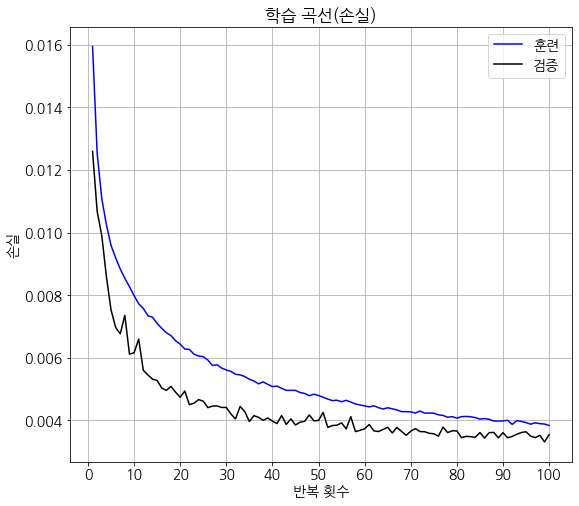

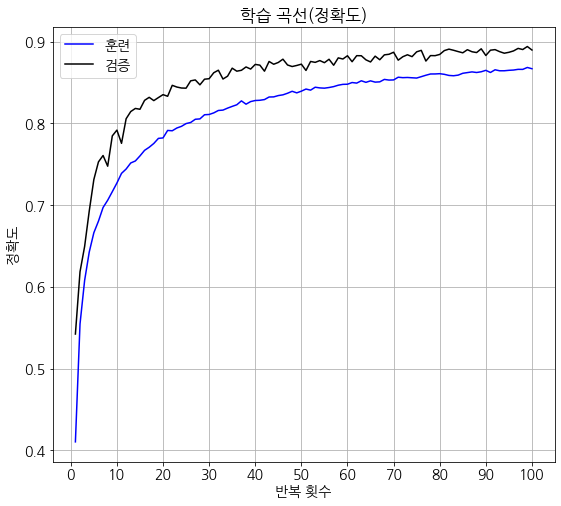

In [ ]:
evaluate_history(history)

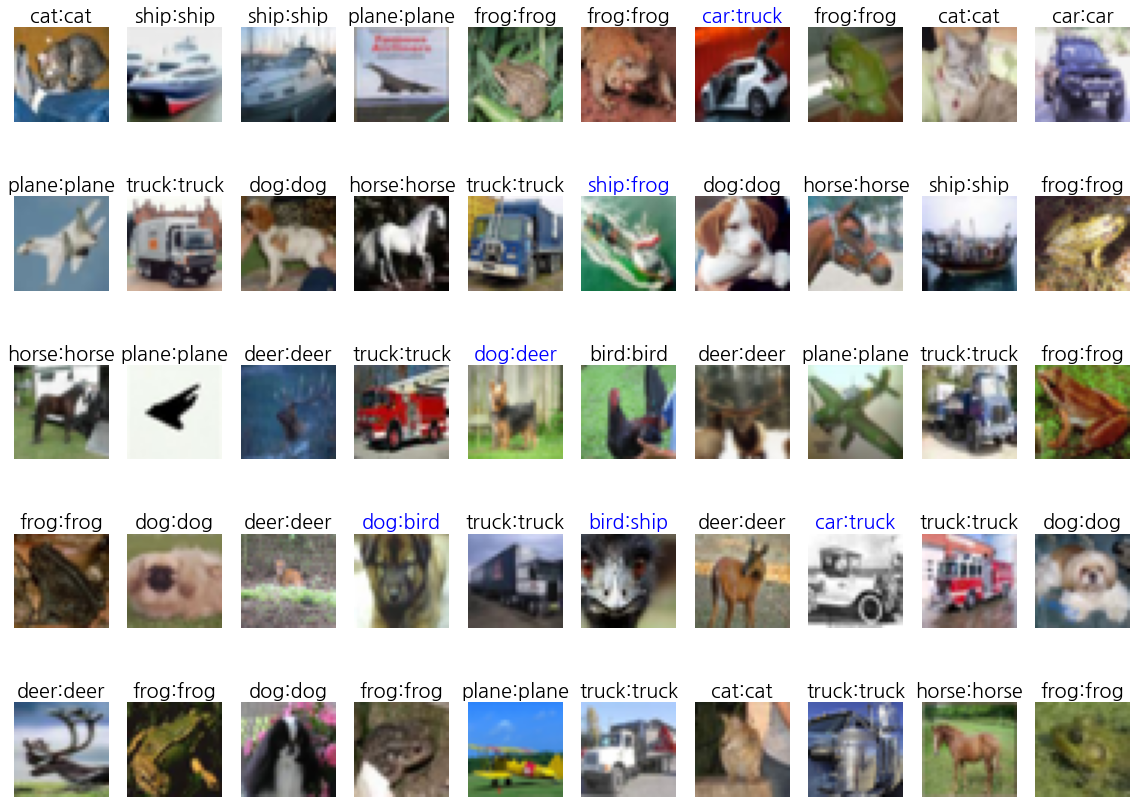

In [ ]:
show_images_labels(test_loader, classes, net, device)

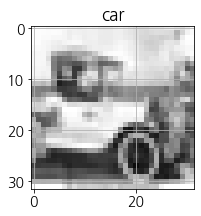

In [ ]:
# 잘못 예측한 38번째 데이터 추출
for images, labels in test_loader:
    break
image = images[37]
label = labels[37]

# 이미지 확인
plt.figure(figsize=(3,3))
w = image.numpy().copy()
w2 = np.transpose(w, (1, 2, 0))
w3 = (w2 + 1)/2 
plt.title(classes[label])
plt.imshow(w3)
plt.show()

In [ ]:
# 예측 값 출력
image = image.view(1, 3, 32, 32)
image = image.to(device)
output = net(image)

# 라벨 별 확률 값 출력
probs = torch.softmax(output, dim=1)
probs_np = probs.data.to('cpu').numpy()[0]
values = np.frompyfunc(lambda x: f'{x:.04f}', 1, 1)(probs_np)
names = np.array(classes)
tbl = np.array([names, values]).T
print(tbl)

[['plane' '0.0000']
 ['car' '0.1837']
 ['bird' '0.0000']
 ['cat' '0.0000']
 ['deer' '0.0000']
 ['dog' '0.0000']
 ['frog' '0.0000']
 ['horse' '0.0000']
 ['ship' '0.0001']
 ['truck' '0.8162']]


## 칼럼 배치 정규화를 사용할 때 주의할 점

### 잘못된 모델 클래스 정의의 예시

In [ ]:
class CNN_v5(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=(1,1))
        self.conv2 = nn.Conv2d(32, 32, 3, padding=(1,1))
        self.conv3 = nn.Conv2d(32, 64, 3, padding=(1,1))
        self.conv4 = nn.Conv2d(64, 64, 3, padding=(1,1))
        self.conv5 = nn.Conv2d(64, 128, 3, padding=(1,1))
        self.conv6 = nn.Conv2d(128, 128, 3, padding=(1,1))
        self.relu = nn.ReLU(inplace=True)
        self.flatten = nn.Flatten()
        self.maxpool = nn.MaxPool2d((2,2))
        self.l1 = nn.Linear(4*4*128, 128)
        self.l2 = nn.Linear(128, 10)
        self.dropout1 = nn.Dropout(0.2)
        self.dropout2 = nn.Dropout(0.3)
        self.dropout3 = nn.Dropout(0.4)
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)

        self.features = nn.Sequential(
            self.conv1,
            self.bn1,
            self.relu,
            self.conv2,
            self.bn1,
            self.relu,
            self.maxpool,
            self.dropout1,
            self.conv3,
            self.bn2,
            self.relu,
            self.conv4,
            self.bn2,
            self.relu,
            self.maxpool,
            self.dropout2,
            self.conv5,
            self.bn3,
            self.relu,
            self.conv6,
            self.bn3,
            self.relu,
            self.maxpool,
            self.dropout3,
            )

        self.classifier = nn.Sequential(
            self.l1,
            self.relu,
            self.dropout3,
            self.l2
        )

    def forward(self, x):
        x1 = self.features(x)
        x2 = self.flatten(x1)
        x3 = self.classifier(x2)
        return x3

In [ ]:
# 난수 고정
torch_seed()

# 모델 인스턴스 생성
net = CNN_v5(n_output).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())
history = np.zeros((0, 5))

In [ ]:
# 학습

num_epochs = 50
history = fit(net, optimizer, criterion, num_epochs, train_loader, test_loader, device, history)

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [1/50], loss: 0.01503 acc: 0.44342 val_loss: 0.02469, val_acc: 0.12240


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [2/50], loss: 0.01125 acc: 0.59616 val_loss: 0.02520, val_acc: 0.11280


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [3/50], loss: 0.00977 acc: 0.65618 val_loss: 0.02589, val_acc: 0.11390


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [4/50], loss: 0.00888 acc: 0.68872 val_loss: 0.03532, val_acc: 0.10020


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [5/50], loss: 0.00824 acc: 0.71612 val_loss: 0.02790, val_acc: 0.10250


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [6/50], loss: 0.00770 acc: 0.73642 val_loss: 0.02827, val_acc: 0.10060


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [7/50], loss: 0.00739 acc: 0.74872 val_loss: 0.03080, val_acc: 0.10110


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [8/50], loss: 0.00694 acc: 0.76410 val_loss: 0.03126, val_acc: 0.13890


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [9/50], loss: 0.00662 acc: 0.77772 val_loss: 0.02612, val_acc: 0.10400


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [10/50], loss: 0.00633 acc: 0.78438 val_loss: 0.02547, val_acc: 0.16510


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [11/50], loss: 0.00603 acc: 0.79664 val_loss: 0.02582, val_acc: 0.16570


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [12/50], loss: 0.00579 acc: 0.80488 val_loss: 0.02622, val_acc: 0.11900


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [13/50], loss: 0.00557 acc: 0.81288 val_loss: 0.02812, val_acc: 0.10370


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [14/50], loss: 0.00539 acc: 0.81844 val_loss: 0.02755, val_acc: 0.10000


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [15/50], loss: 0.00523 acc: 0.82386 val_loss: 0.02608, val_acc: 0.12830


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [16/50], loss: 0.00506 acc: 0.83112 val_loss: 0.02460, val_acc: 0.15680


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [17/50], loss: 0.00488 acc: 0.83512 val_loss: 0.02792, val_acc: 0.13910


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [18/50], loss: 0.00476 acc: 0.83932 val_loss: 0.02734, val_acc: 0.14930


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [19/50], loss: 0.00458 acc: 0.84646 val_loss: 0.02498, val_acc: 0.13110


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [20/50], loss: 0.00442 acc: 0.84990 val_loss: 0.02700, val_acc: 0.12340


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [21/50], loss: 0.00434 acc: 0.85272 val_loss: 0.02480, val_acc: 0.15460


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [22/50], loss: 0.00425 acc: 0.85764 val_loss: 0.02380, val_acc: 0.15000


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [23/50], loss: 0.00414 acc: 0.85986 val_loss: 0.02470, val_acc: 0.12030


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [24/50], loss: 0.00401 acc: 0.86484 val_loss: 0.02446, val_acc: 0.17390


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [25/50], loss: 0.00397 acc: 0.86526 val_loss: 0.02462, val_acc: 0.13460


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [26/50], loss: 0.00390 acc: 0.86856 val_loss: 0.02765, val_acc: 0.10200


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [27/50], loss: 0.00381 acc: 0.86970 val_loss: 0.02703, val_acc: 0.11490


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [28/50], loss: 0.00371 acc: 0.87360 val_loss: 0.02641, val_acc: 0.11270


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [29/50], loss: 0.00364 acc: 0.87656 val_loss: 0.02587, val_acc: 0.11550


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [30/50], loss: 0.00362 acc: 0.87610 val_loss: 0.02860, val_acc: 0.11580


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [31/50], loss: 0.00354 acc: 0.87816 val_loss: 0.02513, val_acc: 0.11340


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [32/50], loss: 0.00349 acc: 0.88020 val_loss: 0.02787, val_acc: 0.13140


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [33/50], loss: 0.00341 acc: 0.88354 val_loss: 0.02461, val_acc: 0.12640


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [34/50], loss: 0.00337 acc: 0.88496 val_loss: 0.02806, val_acc: 0.11110


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [35/50], loss: 0.00331 acc: 0.88720 val_loss: 0.02683, val_acc: 0.10590


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [36/50], loss: 0.00324 acc: 0.88894 val_loss: 0.03001, val_acc: 0.10100


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [37/50], loss: 0.00319 acc: 0.89000 val_loss: 0.02792, val_acc: 0.12420


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [38/50], loss: 0.00312 acc: 0.89266 val_loss: 0.02565, val_acc: 0.12380


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [39/50], loss: 0.00311 acc: 0.89328 val_loss: 0.02664, val_acc: 0.14740


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [40/50], loss: 0.00307 acc: 0.89394 val_loss: 0.02688, val_acc: 0.11660


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [41/50], loss: 0.00302 acc: 0.89436 val_loss: 0.02834, val_acc: 0.10190


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [42/50], loss: 0.00301 acc: 0.89672 val_loss: 0.02754, val_acc: 0.12700


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [43/50], loss: 0.00303 acc: 0.89634 val_loss: 0.02897, val_acc: 0.11920


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [44/50], loss: 0.00291 acc: 0.90076 val_loss: 0.02842, val_acc: 0.10950


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [45/50], loss: 0.00285 acc: 0.90164 val_loss: 0.02845, val_acc: 0.10860


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [46/50], loss: 0.00283 acc: 0.90286 val_loss: 0.02791, val_acc: 0.10300


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [47/50], loss: 0.00281 acc: 0.90404 val_loss: 0.02707, val_acc: 0.16900


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [48/50], loss: 0.00278 acc: 0.90470 val_loss: 0.03003, val_acc: 0.10020


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [49/50], loss: 0.00275 acc: 0.90668 val_loss: 0.02933, val_acc: 0.10550


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [50/50], loss: 0.00275 acc: 0.90740 val_loss: 0.02838, val_acc: 0.10430


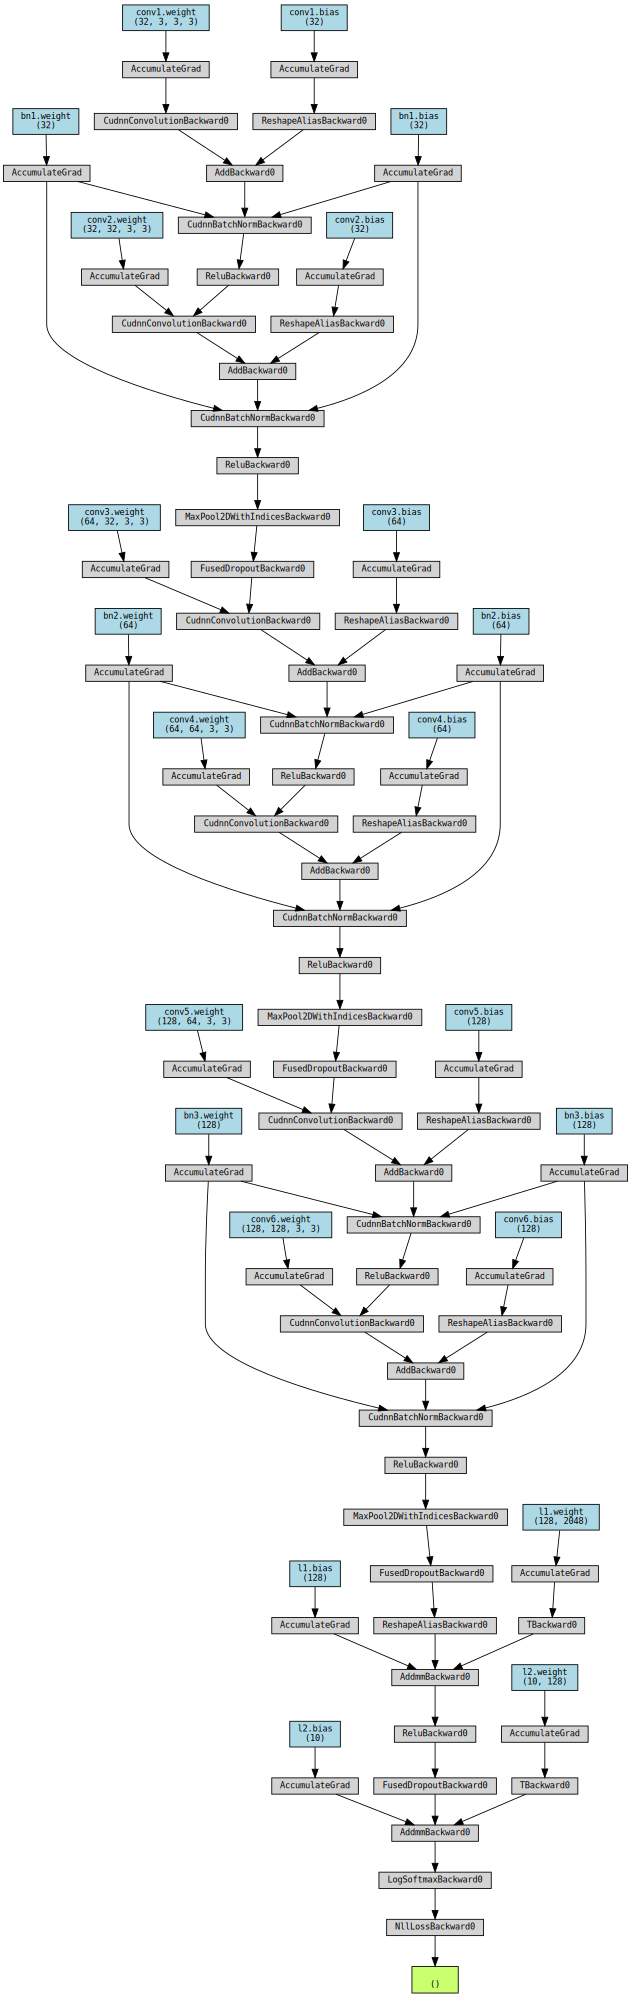

In [ ]:
# 손실 계산 그래프 시각화
net = CNN_v5(n_output).to(device)
criterion = nn.CrossEntropyLoss()
loss = eval_loss(test_loader, device, net, criterion)
g = make_dot(loss, params=dict(net.named_parameters()))
display(g)

## 칼럼 배치 정규화에서 처리하는 내용

In [ ]:
# 입력용 더미 데이터 작성

torch.manual_seed(123)
inputs = torch.randn(1, 1, 10)
print(inputs)

tensor([[[-0.1115,  0.1204, -0.3696, -0.2404, -1.1969,  0.2093, -0.9724,
          -0.7550,  0.3239, -0.1085]]])


In [ ]:
# 입력 미니 배치 데이터의 통계량 산출

i_mean = inputs.mean()
i_var = inputs.var(unbiased=True)
i_std = inputs.std(unbiased=False)
print(i_mean, i_std, i_var)

tensor(-0.3101) tensor(0.4867) tensor(0.2632)


In [ ]:
# BN 함수의 정의

bn = nn.BatchNorm1d(1)
print(bn.running_mean)
print(bn.running_var)
print(bn.weight.data)
print(bn.bias.data)

tensor([0.])
tensor([1.])
tensor([1.])
tensor([0.])


In [ ]:
# BN 함수의 유사 호출

bn.train()
print('===훈련 페이즈 1===')
outputs1 = bn(inputs)
print(outputs1.data)
print(bn.running_mean)
print(bn.running_var)

bn.eval()
print('===예측 페이즈 1===')
outputs2 = bn(inputs)
print(outputs2.data)
print(bn.running_mean)
print(bn.running_var)

bn.train()
print('===훈련 페이즈 2===')
outputs3 = bn(inputs)
print(outputs3.data)
print(bn.running_mean)
print(bn.running_var)

bn.eval()
print('===예측 페이즈 2===')
outputs4 = bn(inputs)
print(outputs4.data)
print(bn.running_mean)
print(bn.running_var)


===훈련 페이즈 1===
tensor([[[ 0.4081,  0.8844, -0.1224,  0.1431, -1.8222,  1.0671, -1.3608,
          -0.9143,  1.3027,  0.4142]]])
tensor([-0.0310])
tensor([0.9263])
===예측 페이즈 1===
tensor([[[-0.0836,  0.1573, -0.3518, -0.2176, -1.2114,  0.2496, -0.9781,
          -0.7523,  0.3688, -0.0805]]])
tensor([-0.0310])
tensor([0.9263])
===훈련 페이즈 2===
tensor([[[ 0.4081,  0.8844, -0.1224,  0.1431, -1.8222,  1.0671, -1.3608,
          -0.9143,  1.3027,  0.4142]]])
tensor([-0.0589])
tensor([0.8600])
===예측 페이즈 2===
tensor([[[-0.0567,  0.1933, -0.3351, -0.1957, -1.2271,  0.2892, -0.9850,
          -0.7507,  0.4128, -0.0535]]])
tensor([-0.0589])
tensor([0.8600])


In [ ]:
# 훈련 페이즈의 출력

xt = (inputs - i_mean)/i_std * bn.weight + bn.bias
print(xt.data)

print(outputs1.data)

tensor([[[ 0.4081,  0.8845, -0.1224,  0.1431, -1.8223,  1.0671, -1.3608,
          -0.9143,  1.3027,  0.4142]]])
tensor([[[ 0.4081,  0.8844, -0.1224,  0.1431, -1.8222,  1.0671, -1.3608,
          -0.9143,  1.3027,  0.4142]]])


In [ ]:
# 예측 페이즈의 출력

xp = (inputs-bn.running_mean)/torch.sqrt(bn.running_var)
print(xp.data)

print(outputs4.data)

tensor([[[-0.0567,  0.1933, -0.3351, -0.1957, -1.2271,  0.2892, -0.9850,
          -0.7507,  0.4128, -0.0535]]])
tensor([[[-0.0567,  0.1933, -0.3351, -0.1957, -1.2271,  0.2892, -0.9850,
          -0.7507,  0.4128, -0.0535]]])


In [ ]:
# running_mean과 runnung_var의 계산식

# 초깃값
mean0 = 0
var0 = 1
momentum = bn.momentum

# 이동 평균 계산 1회차
mean1 = (1-momentum) * mean0 +  momentum * i_mean
var1 = (1-momentum) * var0 +  momentum * i_var
print(mean1, var1)

# 이동 평균 계산 2회차
mean2 = (1-momentum) * mean1 +  momentum * i_mean
var2 = (1-momentum) * var1 +  momentum * i_var
print(mean2, var2)

tensor(-0.0310) tensor(0.9263)
tensor(-0.0589) tensor(0.8600)
